# POS tagging

## RNN

### Data preprocessing

In [1]:
import numpy as np

import tensorflow as tf
import datetime
%load_ext tensorboard

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Please upload data manually to 'data' folder

Custom metrics:

In [3]:
# for logging to tensorboard
# credit goes to https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Reading the data:

In [4]:
import pandas as pd

def data_prep(path):
  with open(path) as f:
    train_data = f.read()
  input = []
  labels = []
  max_sen_len = 0
  unique_words = set()
  unique_labels = set() 
  for line in train_data.split("\n \n"):
    if line=='':
      continue
    in_sen = []
    lab_sen = []
    for word in line.split("\n"):
      seq = word.split(" ")
      in_sen.append(seq[0])
      lab_sen.append(seq[1])
    sen_len = len(in_sen)
    if max_sen_len < sen_len:
      max_sen_len = sen_len  
    unique_words.update(set(in_sen))    
    unique_labels.update(set(lab_sen))  
    input.append(' '.join(word for word in in_sen).strip())
    labels.append(' '.join(word for word in lab_sen).strip())  
  return input, labels, len(unique_words), len(unique_labels), max_sen_len

Preprocessing: get number of unique words and POS, max sentence length, and convert create tensorflow Datasets.

In [5]:
input, labels, u_w, u_l, max_len = data_prep("data/train_pos.txt")

#with open('fra.txt', 'w') as the_file:
#  for i in range(len(input)):
#    the_file.write(input[i])
#    the_file.write('\t') 
#    the_file.write(labels[i]) 
#    the_file.write('\t\n')

print("number of unique words in train:", u_w)
print("number of unique labels in train:", u_l)
print("maximum sentence length in train:", max_len)
train_dataset = tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(input, tf.string),
            tf.cast(labels, tf.string)
        ))
print()
input_test, labels_test, ts_uw, ts_ul, ts_ml = data_prep("data/test_pos.txt")
print("number of unique words in test:", ts_uw)
print("number of unique labels in test:", ts_ul)
print("maximum sentence length in test:", ts_ml)
test_dataset = tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(input, tf.string),
            tf.cast(labels, tf.string)
        ))
print()
train_dataset.element_spec

number of unique words in train: 19122
number of unique labels in train: 44
maximum sentence length in train: 78

number of unique words in test: 8118
number of unique labels in test: 43
maximum sentence length in test: 70



(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Example of what is inside train_dataset:

In [7]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b"Afterward , leaders of the dissident Democrats relented , and said they would n't offer their own proposal as they had planned ."
 b'Steelmakers have also been adding capacity of so-called electrogalvanized steel , which is another way to make coated corrosion-resistant steel .'
 b'Yesterday , the company said the negative after-tax effect on earnings for the year will be about $ 3.3 million .'
 b"Calls to Shelly Schwab , president of MCA TV , were n't returned ."
 b"Harley-Davidson Inc. filed suit in federal court here , alleging that a group that holds 6.2 % of its stock made `` false , deceptive and misleading '' statements in recent regulatory filings and public announcements ."
 b'Second , if the key assumption is valid , Democrats should have lower attendance rates on roll-call votes than Republicans do to the extent that such votes reflect national policy making and that participating in such votes takes away from the time a legislator could otherwise devote to local b

Getting vocabulary with TextVectorization layer:

In [8]:
encoder_l = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=u_l+2, standardize=None, output_sequence_length=max_len)
encoder_l.adapt(train_dataset.map(lambda text, label: label))

In [9]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=u_w+2, standardize=None, output_sequence_length=max_len)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab_l = np.array(encoder_l.get_vocabulary())
vocab_l

array(['', '[UNK]', 'NN', 'IN', 'NNP', 'DT', 'NNS', 'JJ', ',', '.', 'CD',
       'VBD', 'RB', 'VB', 'CC', 'TO', 'VBN', 'VBZ', 'PRP', 'VBG', 'VBP',
       'MD', 'PRP$', 'POS', '$', '``', "''", ':', 'WDT', 'JJR', 'WP',
       'WRB', 'NNPS', 'JJS', 'RBR', ')', '(', 'EX', 'RBS', 'RP', 'PDT',
       'FW', '#', 'WP$', 'UH', 'SYM'], dtype='<U5')

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab

array(['', '[UNK]', ',', ..., "'70s", "'60s", "'40s"], dtype='<U43')

Five encoding examples, then decoding examples:

In [12]:
encoded_example = encoder_l(label).numpy()
print(encoded_example[:5])
for n in range(3):
  print("Original: ", label[n].numpy())
  print("Round-trip: ", " ".join(vocab_l[encoded_example[n]]))
  print()

[[12  8  6  3  5  7 32 11  8 14 11 18 21 12 13 22  7  2  3 18 11 16  9  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 6 20 12 16 19  2  3  7  7  2  8 28 17  5  2 15 13 16  7  2  9  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 2  8  5  2 11  5  7  7  2  3  6  3  5  2 21 13 12 24 10 10  9  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 6 15  4  4  8  2  3  4  2  8 11 12 16  9  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 4  4 11  2  3  7  2 12  8

In [13]:
encoded_example = encoder(example).numpy()
print(encoded_example[:5])
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

[[17728     2  1011     5     3  4054  1035 11131     2     8    18    44
     45    32   309    49   209   577    26    44    61  1128     4     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [15415    35    59    63  1327  2188     5  1501 13496   930     2    46
     17   317   219     6   146  6090  8213   930     4     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [ 1645     2     3    40    18   

Reform tf Datasets after getting the vocabularies from the previous versions. Now labels are one-hot encoded and input words are encoded according to corresponding vocabulary.

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(encoder(input), tf.int64),
            tf.cast(tf.one_hot(encoder_l(labels), depth=u_l), tf.int64)
        ))

test_dataset = tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(encoder(input_test), tf.int64),
            tf.cast(tf.one_hot(encoder_l(labels_test), depth=u_l), tf.int64)
        ))

In [15]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [16]:
for example, label in train_dataset.take(1):
  print('text: ', example)
  print('label: ', label)

text:  tf.Tensor(
[[16884  1443     6 ...     0     0     0]
 [ 6313    18     3 ...     0     0     0]
 [   83   671 10100 ...     0     0     0]
 ...
 [   15  2089    10 ...     0     0     0]
 [ 3283   735   107 ...     0     0     0]
 [  109  2546     5 ...     0     0     0]], shape=(64, 78), dtype=int64)
label:  tf.Tensor(
[[[0 0 1 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 1 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [

### Create the model

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=300,
        # Use masking to handle the variable sequence lengths
        #mask_zero=True
        ),
    tf.keras.layers.SimpleRNN(max_len, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(u_l, activation='softmax'))
])

### Train the model

Credit goes to: https://towardsdatascience.com/pos-tagging-using-rnn-7f08a522f849

In [18]:
logdir = "logs/scalars/" + "rnn"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, 
                                                          write_images=True)
print("rnn train:")
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy', f1_score])
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30, callbacks=[tensorboard_callback])
print("rnn summary:")
model.summary()

rnn train:
Epoch 1/5
140/140 [==============================] - 20s 119ms/step - loss: 1.6834 - accuracy: 0.6691 - f1_score: 0.5356 - val_loss: 0.4846 - val_accuracy: 0.8976 - val_f1_score: 0.8845
Epoch 2/5
140/140 [==============================] - 15s 109ms/step - loss: 0.3601 - accuracy: 0.9305 - f1_score: 0.9123 - val_loss: 0.1680 - val_accuracy: 0.9676 - val_f1_score: 0.9623
Epoch 3/5
140/140 [==============================] - 15s 110ms/step - loss: 0.1045 - accuracy: 0.9843 - f1_score: 0.9775 - val_loss: 0.0975 - val_accuracy: 0.9776 - val_f1_score: 0.9783
Epoch 4/5
140/140 [==============================] - 15s 110ms/step - loss: 0.0448 - accuracy: 0.9926 - f1_score: 0.9907 - val_loss: 0.0790 - val_accuracy: 0.9797 - val_f1_score: 0.9820
Epoch 5/5
140/140 [==============================] - 16s 111ms/step - loss: 0.0265 - accuracy: 0.9948 - f1_score: 0.9944 - val_loss: 0.0728 - val_accuracy: 0.9804 - val_f1_score: 0.9828
rnn summary:
Model: "sequential"
__________________________

### Result

INFO:tensorflow:Assets written to: rnn/assets
32/32 [==============================] - 0s 10ms/step - loss: 0.0731 - accuracy: 0.9803 - f1_score: 0.9826
Test Loss: 0.07312195003032684
Test Accuracy: 0.9803359508514404
F1 Accuracy: 0.9826037883758545


(0.0, 1.0069940656423568)

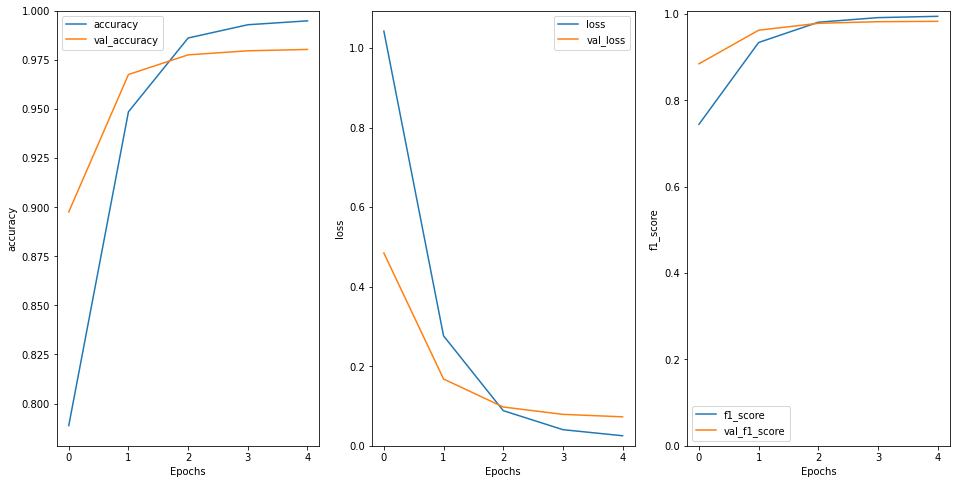

In [19]:
# baseline LSTM test
model.save('rnn')
test_loss, test_acc, f1 = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('F1 Accuracy:', f1)
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 3, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.subplot(1, 3, 3)
plot_graphs(history, 'f1_score')
plt.ylim(0, None)

## HMM with Viterbi

Data prepreocessing for Viterbi:

In [20]:
def data_prep_hmm(path):
  with open(path) as f:
    train_data = f.read()
  data = []
  for line in train_data.split("\n \n"):
    if line=='':
      continue
    #data.append(line)
    sen=[]  
    for word in line.split("\n"):
      seq = word.split(" ")
      sen.append((seq[0], seq[1]))
    data.append(sen)
  return data

train_set, test_set = data_prep_hmm("data/train_pos.txt"), data_prep_hmm("data/test_pos.txt")  

### Claculating emission and transition probabilities

Credit goes to: https://www.mygreatlearning.com/blog/pos-tagging/#:~:text=HMM%20(Hidden%20Markov%20Model)%20is,%2C%20partial%20discharges%2C%20and%20bioinformatics.

In [21]:
import numpy as np
import pandas as pd
import random
import pprint, time

# create list of train and test tagged words
train_tagged_words = [ tup for sent in train_set for tup in sent ]
test_tagged_words = [ tup for sent in test_set for tup in sent ]

#use set datatype to check how many unique tags are present in training data
tags = {tag for word,tag in train_tagged_words}

# check total words in vocabulary
vocab = {word for word,tag in train_tagged_words}

# compute Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)#total number of times the passed tag occurred in train_bag
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    #now calculate the total number of times the passed word occurred as the passed tag.
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

# compute  Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

# creating t x t transition matrix of tags, t= no of tags
# Matrix(i, j) represents P(jth tag after the ith tag)
 
tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        P_t_tprev, P_t = t2_given_t1(t2, t1)
        tags_matrix[i, j] = P_t_tprev/P_t

# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
display(tags_df)

,VBZ,NNS,IN,PRP$,JJS,VBD,UH,VBN,WP$,RB,WP,CC,",",CD,DT,'',FW,POS,MD,VB,TO,SYM,NN,VBG,WRB,NNPS,.,JJ,``,$,RBR,WDT,NNP,PDT,:,),#,EX,RP,VBP,RBS,JJR,(,PRP
VBZ,0.001506,0.017212,0.095955,0.010112,0.000430,0.003442,0.000000,0.144578,0.000000,0.134466,0.002582,0.003657,0.027969,0.017857,0.168675,0.000000,0.000000,0.000000,0.001721,0.002582,0.045396,0.000000,0.039587,0.051205,0.007745,0.000000,0.029045,0.075947,0.008391,0.004518,0.002151,0.000645,0.061747,0.000215,0.004948,0.000000,0.000000,0.000861,0.001506,0.001291,0.001506,0.007960,0.000215,0.022375
NNS,0.007049,0.011234,0.231515,0.000734,0.000147,0.078860,0.000000,0.022983,0.000514,0.031941,0.008004,0.059623,0.118217,0.001983,0.017622,0.003818,0.000000,0.009839,0.028710,0.001248,0.040311,0.000000,0.018504,0.014759,0.002350,0.000073,0.132315,0.018871,0.002497,0.000147,0.001689,0.011601,0.003084,0.000000,0.019678,0.001395,0.000000,0.000441,0.000000,0.088479,0.000294,0.001101,0.003892,0.004479
IN,0.001318,0.061545,0.029740,0.036681,0.003031,0.000176,0.000000,0.005843,0.000000,0.014980,0.002416,0.001845,0.004481,0.062116,0.326173,0.000527,0.000220,0.000000,0.000176,0.000439,0.003426,0.000000,0.111536,0.027719,0.001713,0.001889,0.000791,0.084168,0.006062,0.027851,0.000483,0.003251,0.136795,0.001230,0.000439,0.000044,0.000703,0.001450,0.000000,0.000351,0.001801,0.005359,0.000439,0.030794
PRP$,0.000000,0.201489,0.000000,0.000000,0.012228,0.001063,0.000000,0.012228,0.000000,0.007443,0.000000,0.000532,0.001595,0.017544,0.000532,0.000000,0.000532,0.000000,0.000000,0.000532,0.000000,0.000000,0.447634,0.003721,0.000000,0.000532,0.001063,0.216374,0.003190,0.004253,0.000000,0.000000,0.057416,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000532,0.004785,0.004253,0.000000,0.000532
JJS,0.010695,0.144385,0.106952,0.000000,0.000000,0.002674,0.000000,0.000000,0.000000,0.021390,0.000000,0.005348,0.021390,0.072193,0.040107,0.002674,0.000000,0.000000,0.002674,0.008021,0.000000,0.000000,0.401070,0.013369,0.002674,0.002674,0.008021,0.088235,0.002674,0.005348,0.000000,0.000000,0.008021,0.000000,0.005348,0.000000,0.000000,0.000000,0.000000,0.010695,0.000000,0.000000,0.000000,0.013369
VBD,0.000890,0.025352,0.136101,0.023573,0.000148,0.001779,0.000000,0.091179,0.000000,0.077835,0.000593,0.003262,0.026093,0.072498,0.153892,0.000297,0.000000,0.000000,0.000445,0.003410,0.060489,0.000000,0.043440,0.026390,0.001038,0.000000,0.047443,0.061972,0.007709,0.017643,0.001038,0.000741,0.045219,0.000297,0.002817,0.000148,0.000000,0.001483,0.001631,0.000148,0.000297,0.009192,0.000297,0.053225
UH,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.066667,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667
VBN,0.001680,0.044300,0.363216,0.010288,0.000000,0.001050,0.000000,0.031283,0.000000,0.042410,0.000840,0.013227,0.029813,0.018686,0.064665,0.002939,0.000000,0.000000,0.001470,0.001050,0.104976,0.000000,0.090909,0.015956,0.002939,0.000210,0.044720,0.045560,0.004829,0.008188,0.001680,0.000420,0.030863,0.000420,0.003989,0.001050,0.000210,0.000000,0.000840,0.001050,0.000210,0.005669,0.000210,0.008188
WP$,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.371429,0.028571,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.114286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000
RB,0.041017,0.004995,0.129257,0.002724,0.000605,0.050552,0.000000,0.086272,0.000000,0.058877,0.001665,0.007114,0.093234,0.022855,0.050704,0.001059,0.000151,0.000454,0.011503,0.109732,0.025428,0.000151,0.008022,0.030725,0.003481,0.000303,0.062509,0.102

### Viterbi

In [22]:
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
     
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = np.log(tags_df.loc['.', tag])
            else:
                transition_p = np.log(tags_df.loc[state[-1], tag])
                 
            # compute emission and state probabilities
            P_t_tprev, P_t = word_given_tag(words[key], tag)
            emission_p = np.log(P_t_tprev) - np.log(P_t)
            state_probability = emission_p + transition_p    
            p.append(state_probability)
             
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


# Let's test our Viterbi algorithm on a few sample sentences of test dataset
random.seed(111)
 
# Here we will only test 10 sentences to check the accuracy
rndom = [random.randint(1,len(test_set)) for x in range(10)]

test_run = [test_set[i] for i in rndom] 
test_run_base = [tup for sent in test_run for tup in sent]
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
tagged_seq = Viterbi(test_tagged_words)
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Viterbi Algorithm Accuracy: ',accuracy*100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


Viterbi Algorithm Accuracy:  88.42105263157895


Output check:

In [23]:
#Check how a sentence is tagged by the two POS taggers
#and compare them
test_sent="Confidence in the pound is widely expected to take another sharp dive if trade figures for September , due for release tomorrow , fail to show a substantial improvement from July Nand August 's near-record deficits ."
pred_tags = Viterbi(test_sent.split())
print(pred_tags)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


[('Confidence', 'NN'), ('in', 'IN'), ('the', 'DT'), ('pound', 'NN'), ('is', 'VBZ'), ('widely', 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('take', 'VB'), ('another', 'DT'), ('sharp', 'JJ'), ('dive', 'NN'), ('if', 'IN'), ('trade', 'NN'), ('figures', 'NNS'), ('for', 'IN'), ('September', 'NNP'), (',', ','), ('due', 'JJ'), ('for', 'IN'), ('release', 'NN'), ('tomorrow', 'NN'), (',', ','), ('fail', 'VB'), ('to', 'TO'), ('show', 'VB'), ('a', 'DT'), ('substantial', 'JJ'), ('improvement', 'NN'), ('from', 'IN'), ('July', 'NNP'), ('Nand', 'VBZ'), ('August', 'NNP'), ("'s", 'POS'), ('near-record', 'JJ'), ('deficits', 'NNS'), ('.', '.')]
